In [1]:
!pip install torchinfo

In [2]:
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle  # ✅ Add this line
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, roc_curve, auc)
import matplotlib.pyplot as plt

In [3]:
cpu_info = platform.processor()
ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)
try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"
print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
data_dir = "/kaggle/input/Fish Data raw/Fish Data"
file_paths = []
labels = []
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)
df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Rui, Count: 2500
Class: Taki, Count: 2223
Class: Telapiya, Count: 2058
Class: Mrigel, Count: 1808
Class: Aair, Count: 1804
Class: Katla, Count: 1765
Class: Pabda, Count: 1764
Class: Boal, Count: 1651
Class: Puti, Count: 1560
Class: Tengra, Count: 1431
Class: Shol, Count: 1424
Class: Tarabaim, Count: 1262
Class: Ilish, Count: 1031
Class: Pangas, Count: 934
Class: KalBaush, Count: 917
Class: Koi, Count: 842
Class: Magur, Count: 574
Class: Foli, Count: 562
Class: Chapila, Count: 428
Class: DeshiPuti, Count: 412


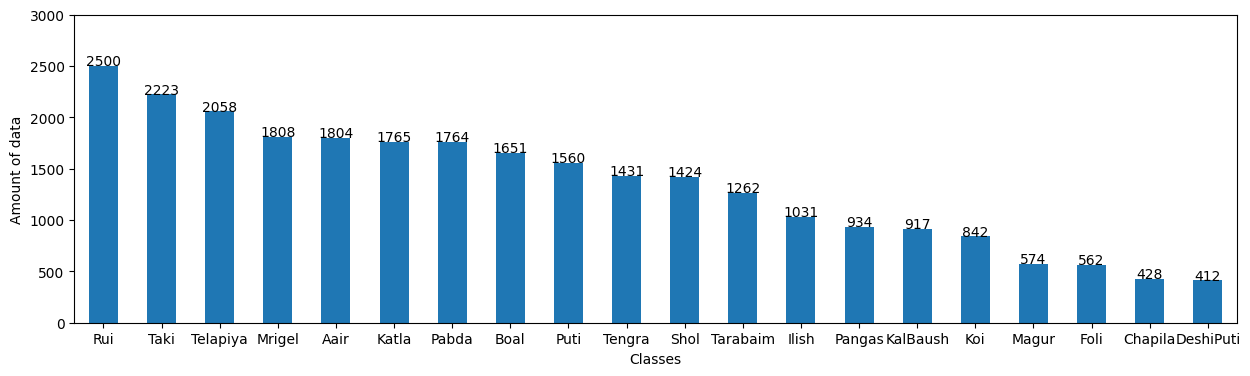

In [6]:
class_counts_train = df['label'].value_counts()
for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")
plt.figure(figsize=(15, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

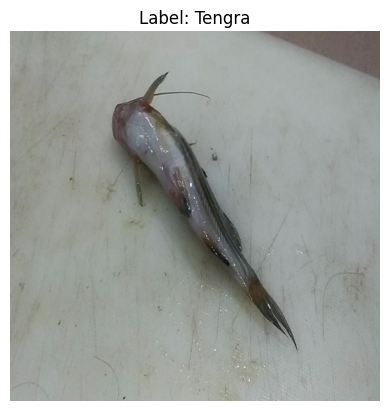

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]
file_path = random_row['file_path']
label = random_row['label']
image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18865
Validation Data:  4042
Test Data:  4043
-------------------------------------------
Total amounts of data in the dataset:  26950


In [10]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()
train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]
print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class        Count
---------  -------
Rui           1750
Taki          1556
Telapiya      1441
Mrigel        1265
Aair          1263
Pabda         1235
Katla         1235
Boal          1156
Puti          1092
Tengra        1002
Shol           997
Tarabaim       883
Ilish          722
Pangas         654
KalBaush       642
Koi            589
Magur          402
Foli           393
Chapila        300
DeshiPuti      288

Validation Dataset
Class        Count
---------  -------
Rui            375
Taki           333
Telapiya       308
Mrigel         271
Aair           270
Katla          265
Pabda          264
Boal           247
Puti           234
Shol           214
Tengra         214
Tarabaim       190
Ilish          155
Pangas         140
KalBaush       138
Koi            127
Magur           86
Foli            85
Chapila         64
DeshiPuti       62

Test Dataset
Class        Count
---------  -------
Rui            375
Taki           334
Telapiya       309
Mrigel         272
Aa

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)
        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [15]:
train_batch = 32
val_batch = 8
def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])
    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )
    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )
    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )
    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset
# Call the function and extract datasets
normalize = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
valid_dataset = ImageDataset(valid_dataframe, normalize, is_lb=True)
test_dataset = ImageDataset(test_df, normalize, is_lb=True)  # ← Now defined globally!

# Create DataLoaders
dataloader_train_dataset = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
dataloader_test_dataset = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

# Attention blocks

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Channel Attention Module (part of CBAM)
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module (part of CBAM)
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# CBAM (Convolutional Block Attention Module)
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)
    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)
        out = self.gamma * out + x
        return out

# GCNet Attention (Global Context Block)
class GCBlock(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(GCBlock, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        mip = max(8, in_channels // ratio)
        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = nn.ReLU(inplace=True)
        self.conv_h = nn.Conv2d(mip, in_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, in_channels, kernel_size=1, stride=1, padding=0)
    def forward(self, x):
        identity = x
        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)
        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()
        out = identity * a_w * a_h
        return out

In [17]:
# Enhanced FishNet with Attention Mechanisms
class FishNetWithAttention(nn.Module):
    def __init__(self, num_classes, attention_type='cbam'):
        super(FishNetWithAttention, self).__init__()
        self.attention_type = attention_type
        self.features = nn.Sequential()
        self.features.add_module('conv1', nn.Conv2d(3, 32, 3, padding=1))
        self.features.add_module('bn1', nn.BatchNorm2d(32))
        self.features.add_module('relu1', nn.ReLU())
        self.features.add_module('pool1', nn.MaxPool2d(2, 2))
        if attention_type == 'se':
            self.features.add_module('se1', SEBlock(32))
        elif attention_type == 'cbam':
            self.features.add_module('cbam1', CBAM(32))
        elif attention_type == 'self':
            self.features.add_module('self1', SelfAttention(32))
        elif attention_type == 'gc':
            self.features.add_module('gc1', GCBlock(32))

        self.features.add_module('conv2', nn.Conv2d(32, 64, 3, padding=1))
        self.features.add_module('bn2', nn.BatchNorm2d(64))
        self.features.add_module('relu2', nn.ReLU())
        self.features.add_module('pool2', nn.MaxPool2d(2, 2))
        if attention_type == 'se':
            self.features.add_module('se2', SEBlock(64))
        elif attention_type == 'cbam':
            self.features.add_module('cbam2', CBAM(64))
        elif attention_type == 'self':
            self.features.add_module('self2', SelfAttention(64))
        elif attention_type == 'gc':
            self.features.add_module('gc2', GCBlock(64))

        self.features.add_module('conv3', nn.Conv2d(64, 128, 3, padding=1))
        self.features.add_module('bn3', nn.BatchNorm2d(128))
        self.features.add_module('relu3', nn.ReLU())
        self.features.add_module('pool3', nn.MaxPool2d(2, 2))
        if attention_type == 'se':
            self.features.add_module('se3', SEBlock(128))
        elif attention_type == 'cbam':
            self.features.add_module('cbam3', CBAM(128))
        elif attention_type == 'self':
            self.features.add_module('self3', SelfAttention(128))
        elif attention_type == 'gc':
            self.features.add_module('gc3', GCBlock(128))

        self.features.add_module('conv4', nn.Conv2d(128, 256, 3, padding=1))
        self.features.add_module('bn4', nn.BatchNorm2d(256))
        self.features.add_module('relu4', nn.ReLU())
        self.features.add_module('pool4', nn.MaxPool2d(2, 2))
        if attention_type == 'se':
            self.features.add_module('se4', SEBlock(256))
        elif attention_type == 'cbam':
            self.features.add_module('cbam4', CBAM(256))
        elif attention_type == 'self':
            self.features.add_module('self4', SelfAttention(256))
        elif attention_type == 'gc':
            self.features.add_module('gc4', GCBlock(256))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [18]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_val_acc = 0.0
    os.makedirs(save_path_checkpoints, exist_ok=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item() * val_images.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save({
                'epoch': epoch,
                'model_weight': model.state_dict(),
                'optimizer_state': optimizer.state_dict()
            }, f"{save_path_checkpoints}/model.pt")
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [19]:
# Evaluation function
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = running_loss / total
    accuracy = correct / total
    return loss, accuracy

# Class accuracy function
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    return [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

# Feature extraction function
def extract_features(extractor, data_loader, device):
    extractor.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            feats = extractor(images)
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

# Function to create different attention-based models
def create_attention_model(num_classes, attention_type):
    return FishNetWithAttention(num_classes, attention_type).to(device)

# Feature extractor for attention models
def create_feature_extractor_with_attention(original_model):
    class FishNetFeaturesWithAttention(nn.Module):
        def __init__(self, original_model):
            super(FishNetFeaturesWithAttention, self).__init__()
            self.features = original_model.features
            self.classifier_part = nn.Sequential(*list(original_model.classifier.children())[:-3])
        def forward(self, x):
            x = self.features(x)
            x = self.classifier_part(x)
            return x
    return FishNetFeaturesWithAttention(original_model).to(device)

Starting Attention-Based Model Training...

Training FishNet with CBAM Attention


Epoch 1/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 1/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 1/150 | Train Loss: 1.5586 | Train Acc: 0.4930 | Val Loss: 0.5176 | Val Acc: 0.8377


Epoch 2/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 2/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/150 | Train Loss: 0.5788 | Train Acc: 0.8084 | Val Loss: 0.2458 | Val Acc: 0.9221


Epoch 3/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 3/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/150 | Train Loss: 0.3380 | Train Acc: 0.8896 | Val Loss: 0.1757 | Val Acc: 0.9463


Epoch 4/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 4/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/150 | Train Loss: 0.2251 | Train Acc: 0.9265 | Val Loss: 0.1808 | Val Acc: 0.9389


Epoch 5/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 5/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/150 | Train Loss: 0.1678 | Train Acc: 0.9466 | Val Loss: 0.0986 | Val Acc: 0.9711


Epoch 6/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 6/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 6/150 | Train Loss: 0.1324 | Train Acc: 0.9575 | Val Loss: 0.0781 | Val Acc: 0.9740


Epoch 7/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 7/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/150 | Train Loss: 0.1044 | Train Acc: 0.9649 | Val Loss: 0.0711 | Val Acc: 0.9780


Epoch 8/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 8/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/150 | Train Loss: 0.0896 | Train Acc: 0.9699 | Val Loss: 0.0908 | Val Acc: 0.9723


Epoch 9/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 9/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/150 | Train Loss: 0.0798 | Train Acc: 0.9741 | Val Loss: 0.0700 | Val Acc: 0.9782


Epoch 10/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 10/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/150 | Train Loss: 0.0708 | Train Acc: 0.9769 | Val Loss: 0.0683 | Val Acc: 0.9797


Epoch 11/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 11/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 11/150 | Train Loss: 0.0686 | Train Acc: 0.9779 | Val Loss: 0.0734 | Val Acc: 0.9802


Epoch 12/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 12/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/150 | Train Loss: 0.0620 | Train Acc: 0.9795 | Val Loss: 0.0716 | Val Acc: 0.9810


Epoch 13/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 13/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/150 | Train Loss: 0.0501 | Train Acc: 0.9846 | Val Loss: 0.0583 | Val Acc: 0.9819


Epoch 14/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 14/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/150 | Train Loss: 0.0466 | Train Acc: 0.9849 | Val Loss: 0.0847 | Val Acc: 0.9743


Epoch 15/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 15/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/150 | Train Loss: 0.0427 | Train Acc: 0.9855 | Val Loss: 0.0759 | Val Acc: 0.9800


Epoch 16/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 16/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 16/150 | Train Loss: 0.0466 | Train Acc: 0.9849 | Val Loss: 0.0732 | Val Acc: 0.9780


Epoch 17/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 17/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/150 | Train Loss: 0.0343 | Train Acc: 0.9891 | Val Loss: 0.0768 | Val Acc: 0.9797


Epoch 18/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 18/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/150 | Train Loss: 0.0422 | Train Acc: 0.9861 | Val Loss: 0.0657 | Val Acc: 0.9832


Epoch 19/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 19/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/150 | Train Loss: 0.0324 | Train Acc: 0.9893 | Val Loss: 0.0773 | Val Acc: 0.9807


Epoch 20/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 20/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/150 | Train Loss: 0.0349 | Train Acc: 0.9888 | Val Loss: 0.0530 | Val Acc: 0.9871


Epoch 21/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 21/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 21/150 | Train Loss: 0.0300 | Train Acc: 0.9907 | Val Loss: 0.0622 | Val Acc: 0.9847


Epoch 22/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 22/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 22/150 | Train Loss: 0.0326 | Train Acc: 0.9904 | Val Loss: 0.0643 | Val Acc: 0.9822


Epoch 23/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 23/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 23/150 | Train Loss: 0.0294 | Train Acc: 0.9901 | Val Loss: 0.0585 | Val Acc: 0.9849


Epoch 24/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 24/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 24/150 | Train Loss: 0.0304 | Train Acc: 0.9901 | Val Loss: 0.0717 | Val Acc: 0.9864


Epoch 25/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 25/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 25/150 | Train Loss: 0.0255 | Train Acc: 0.9922 | Val Loss: 0.0679 | Val Acc: 0.9837


Epoch 26/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 26/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 26/150 | Train Loss: 0.0267 | Train Acc: 0.9910 | Val Loss: 0.1055 | Val Acc: 0.9760


Epoch 27/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 27/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 27/150 | Train Loss: 0.0209 | Train Acc: 0.9936 | Val Loss: 0.0554 | Val Acc: 0.9876


Epoch 28/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 28/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 28/150 | Train Loss: 0.0237 | Train Acc: 0.9924 | Val Loss: 0.0593 | Val Acc: 0.9874


Epoch 29/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 29/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 29/150 | Train Loss: 0.0274 | Train Acc: 0.9924 | Val Loss: 0.0503 | Val Acc: 0.9866


Epoch 30/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 30/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 30/150 | Train Loss: 0.0268 | Train Acc: 0.9913 | Val Loss: 0.0559 | Val Acc: 0.9857


Epoch 31/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 31/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 31/150 | Train Loss: 0.0195 | Train Acc: 0.9939 | Val Loss: 0.0588 | Val Acc: 0.9849


Epoch 32/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 32/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 32/150 | Train Loss: 0.0192 | Train Acc: 0.9945 | Val Loss: 0.0696 | Val Acc: 0.9842


Epoch 33/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 33/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 33/150 | Train Loss: 0.0236 | Train Acc: 0.9928 | Val Loss: 0.0578 | Val Acc: 0.9852


Epoch 34/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 34/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 34/150 | Train Loss: 0.0244 | Train Acc: 0.9917 | Val Loss: 0.0752 | Val Acc: 0.9852


Epoch 35/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 35/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 35/150 | Train Loss: 0.0162 | Train Acc: 0.9945 | Val Loss: 0.0535 | Val Acc: 0.9884


Epoch 36/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 36/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 36/150 | Train Loss: 0.0184 | Train Acc: 0.9949 | Val Loss: 0.0599 | Val Acc: 0.9866


Epoch 37/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 37/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 37/150 | Train Loss: 0.0151 | Train Acc: 0.9948 | Val Loss: 0.0573 | Val Acc: 0.9859


Epoch 38/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 38/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 38/150 | Train Loss: 0.0208 | Train Acc: 0.9944 | Val Loss: 0.0458 | Val Acc: 0.9889


Epoch 39/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 39/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 39/150 | Train Loss: 0.0156 | Train Acc: 0.9952 | Val Loss: 0.0483 | Val Acc: 0.9891


Epoch 40/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 40/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 40/150 | Train Loss: 0.0108 | Train Acc: 0.9962 | Val Loss: 0.0662 | Val Acc: 0.9859


Epoch 41/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 41/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 41/150 | Train Loss: 0.0160 | Train Acc: 0.9951 | Val Loss: 0.1407 | Val Acc: 0.9651


Epoch 42/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 42/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 42/150 | Train Loss: 0.0171 | Train Acc: 0.9946 | Val Loss: 0.0823 | Val Acc: 0.9807


Epoch 43/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 43/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 43/150 | Train Loss: 0.0165 | Train Acc: 0.9945 | Val Loss: 0.0603 | Val Acc: 0.9832


Epoch 44/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 44/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 44/150 | Train Loss: 0.0132 | Train Acc: 0.9963 | Val Loss: 0.0593 | Val Acc: 0.9874


Epoch 45/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 45/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 45/150 | Train Loss: 0.0159 | Train Acc: 0.9957 | Val Loss: 0.0527 | Val Acc: 0.9869


Epoch 46/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 46/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 46/150 | Train Loss: 0.0120 | Train Acc: 0.9962 | Val Loss: 0.0765 | Val Acc: 0.9827


Epoch 47/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 47/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 47/150 | Train Loss: 0.0167 | Train Acc: 0.9948 | Val Loss: 0.0621 | Val Acc: 0.9859


Epoch 48/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 48/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 48/150 | Train Loss: 0.0140 | Train Acc: 0.9958 | Val Loss: 0.0477 | Val Acc: 0.9894


Epoch 49/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 49/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 49/150 | Train Loss: 0.0129 | Train Acc: 0.9964 | Val Loss: 0.0543 | Val Acc: 0.9889


Epoch 50/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 50/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 50/150 | Train Loss: 0.0113 | Train Acc: 0.9962 | Val Loss: 0.0795 | Val Acc: 0.9812


Epoch 51/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 51/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 51/150 | Train Loss: 0.0130 | Train Acc: 0.9962 | Val Loss: 0.0466 | Val Acc: 0.9896


Epoch 52/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 52/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 52/150 | Train Loss: 0.0112 | Train Acc: 0.9970 | Val Loss: 0.0522 | Val Acc: 0.9884


Epoch 53/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 53/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 53/150 | Train Loss: 0.0138 | Train Acc: 0.9958 | Val Loss: 0.0443 | Val Acc: 0.9886


Epoch 54/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 54/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 54/150 | Train Loss: 0.0095 | Train Acc: 0.9977 | Val Loss: 0.0586 | Val Acc: 0.9866


Epoch 55/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 55/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 55/150 | Train Loss: 0.0099 | Train Acc: 0.9970 | Val Loss: 0.0418 | Val Acc: 0.9904


Epoch 56/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 56/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 56/150 | Train Loss: 0.0149 | Train Acc: 0.9959 | Val Loss: 0.3427 | Val Acc: 0.9337


Epoch 57/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 57/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 57/150 | Train Loss: 0.0158 | Train Acc: 0.9958 | Val Loss: 0.0562 | Val Acc: 0.9844


Epoch 58/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 58/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 58/150 | Train Loss: 0.0089 | Train Acc: 0.9968 | Val Loss: 0.0418 | Val Acc: 0.9906


Epoch 59/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 59/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 59/150 | Train Loss: 0.0097 | Train Acc: 0.9970 | Val Loss: 0.0571 | Val Acc: 0.9899


Epoch 60/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 60/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 60/150 | Train Loss: 0.0077 | Train Acc: 0.9977 | Val Loss: 0.0500 | Val Acc: 0.9896


Epoch 61/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 61/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 61/150 | Train Loss: 0.0119 | Train Acc: 0.9964 | Val Loss: 0.0666 | Val Acc: 0.9849


Epoch 62/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 62/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 62/150 | Train Loss: 0.0146 | Train Acc: 0.9956 | Val Loss: 0.0480 | Val Acc: 0.9899


Epoch 63/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 63/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 63/150 | Train Loss: 0.0117 | Train Acc: 0.9960 | Val Loss: 0.1233 | Val Acc: 0.9802


Epoch 64/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 64/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 64/150 | Train Loss: 0.0113 | Train Acc: 0.9968 | Val Loss: 0.0600 | Val Acc: 0.9911


Epoch 65/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 65/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 65/150 | Train Loss: 0.0080 | Train Acc: 0.9973 | Val Loss: 0.0495 | Val Acc: 0.9899


Epoch 66/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 66/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 66/150 | Train Loss: 0.0135 | Train Acc: 0.9962 | Val Loss: 0.1179 | Val Acc: 0.9780


Epoch 67/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 67/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 67/150 | Train Loss: 0.0068 | Train Acc: 0.9979 | Val Loss: 0.0515 | Val Acc: 0.9901


Epoch 68/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 68/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 68/150 | Train Loss: 0.0062 | Train Acc: 0.9980 | Val Loss: 0.0427 | Val Acc: 0.9906


Epoch 69/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 69/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 69/150 | Train Loss: 0.0066 | Train Acc: 0.9982 | Val Loss: 0.0646 | Val Acc: 0.9859


Epoch 70/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 70/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 70/150 | Train Loss: 0.0080 | Train Acc: 0.9977 | Val Loss: 0.0437 | Val Acc: 0.9896


Epoch 71/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 71/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 71/150 | Train Loss: 0.0118 | Train Acc: 0.9969 | Val Loss: 0.0439 | Val Acc: 0.9884


Epoch 72/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 72/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 72/150 | Train Loss: 0.0101 | Train Acc: 0.9971 | Val Loss: 0.0522 | Val Acc: 0.9869


Epoch 73/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 73/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 73/150 | Train Loss: 0.0084 | Train Acc: 0.9974 | Val Loss: 0.0317 | Val Acc: 0.9926


Epoch 74/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 74/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 74/150 | Train Loss: 0.0062 | Train Acc: 0.9984 | Val Loss: 0.0467 | Val Acc: 0.9904


Epoch 75/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 75/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 75/150 | Train Loss: 0.0083 | Train Acc: 0.9975 | Val Loss: 0.0471 | Val Acc: 0.9896


Epoch 76/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 76/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 76/150 | Train Loss: 0.0111 | Train Acc: 0.9968 | Val Loss: 0.0428 | Val Acc: 0.9891


Epoch 77/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 77/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 77/150 | Train Loss: 0.0095 | Train Acc: 0.9971 | Val Loss: 0.0450 | Val Acc: 0.9906


Epoch 78/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 78/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 78/150 | Train Loss: 0.0059 | Train Acc: 0.9979 | Val Loss: 0.0467 | Val Acc: 0.9908


Epoch 79/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 79/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 79/150 | Train Loss: 0.0062 | Train Acc: 0.9982 | Val Loss: 0.0664 | Val Acc: 0.9861


Epoch 80/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 80/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 80/150 | Train Loss: 0.0110 | Train Acc: 0.9970 | Val Loss: 0.0605 | Val Acc: 0.9886


Epoch 81/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 81/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 81/150 | Train Loss: 0.0069 | Train Acc: 0.9979 | Val Loss: 0.0562 | Val Acc: 0.9891


Epoch 82/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 82/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 82/150 | Train Loss: 0.0089 | Train Acc: 0.9973 | Val Loss: 0.0642 | Val Acc: 0.9879


Epoch 83/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 83/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 83/150 | Train Loss: 0.0066 | Train Acc: 0.9978 | Val Loss: 0.0710 | Val Acc: 0.9879


Epoch 84/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 84/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 84/150 | Train Loss: 0.0104 | Train Acc: 0.9964 | Val Loss: 0.0496 | Val Acc: 0.9896


Epoch 85/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 85/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 85/150 | Train Loss: 0.0052 | Train Acc: 0.9983 | Val Loss: 0.0516 | Val Acc: 0.9908


Epoch 86/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 86/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 86/150 | Train Loss: 0.0069 | Train Acc: 0.9980 | Val Loss: 0.0399 | Val Acc: 0.9901


Epoch 87/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 87/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 87/150 | Train Loss: 0.0094 | Train Acc: 0.9972 | Val Loss: 0.0438 | Val Acc: 0.9901


Epoch 88/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 88/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 88/150 | Train Loss: 0.0092 | Train Acc: 0.9976 | Val Loss: 0.0412 | Val Acc: 0.9908


Epoch 89/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 89/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 89/150 | Train Loss: 0.0050 | Train Acc: 0.9983 | Val Loss: 0.0645 | Val Acc: 0.9869


Epoch 90/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 90/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 90/150 | Train Loss: 0.0108 | Train Acc: 0.9972 | Val Loss: 0.0363 | Val Acc: 0.9933


Epoch 91/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 91/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 91/150 | Train Loss: 0.0047 | Train Acc: 0.9986 | Val Loss: 0.0405 | Val Acc: 0.9913


Epoch 92/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 92/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 92/150 | Train Loss: 0.0078 | Train Acc: 0.9983 | Val Loss: 0.0478 | Val Acc: 0.9901


Epoch 93/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 93/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 93/150 | Train Loss: 0.0079 | Train Acc: 0.9974 | Val Loss: 0.0513 | Val Acc: 0.9894


Epoch 94/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 94/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 94/150 | Train Loss: 0.0081 | Train Acc: 0.9975 | Val Loss: 0.0380 | Val Acc: 0.9921


Epoch 95/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 95/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 95/150 | Train Loss: 0.0055 | Train Acc: 0.9986 | Val Loss: 0.0404 | Val Acc: 0.9901


Epoch 96/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 96/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 96/150 | Train Loss: 0.0064 | Train Acc: 0.9981 | Val Loss: 0.0469 | Val Acc: 0.9904


Epoch 97/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 97/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 97/150 | Train Loss: 0.0063 | Train Acc: 0.9979 | Val Loss: 0.0573 | Val Acc: 0.9881


Epoch 98/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 98/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 98/150 | Train Loss: 0.0070 | Train Acc: 0.9978 | Val Loss: 0.0531 | Val Acc: 0.9894


Epoch 99/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 99/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 99/150 | Train Loss: 0.0054 | Train Acc: 0.9982 | Val Loss: 0.0466 | Val Acc: 0.9916


Epoch 100/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 100/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 100/150 | Train Loss: 0.0081 | Train Acc: 0.9975 | Val Loss: 0.0462 | Val Acc: 0.9904


Epoch 101/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 101/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 101/150 | Train Loss: 0.0069 | Train Acc: 0.9980 | Val Loss: 0.0557 | Val Acc: 0.9904


Epoch 102/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 102/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 102/150 | Train Loss: 0.0080 | Train Acc: 0.9979 | Val Loss: 0.0565 | Val Acc: 0.9904


Epoch 103/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 103/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 103/150 | Train Loss: 0.0068 | Train Acc: 0.9979 | Val Loss: 0.0742 | Val Acc: 0.9844


Epoch 104/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 104/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 104/150 | Train Loss: 0.0037 | Train Acc: 0.9986 | Val Loss: 0.0493 | Val Acc: 0.9913


Epoch 105/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 105/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 105/150 | Train Loss: 0.0062 | Train Acc: 0.9979 | Val Loss: 0.0663 | Val Acc: 0.9891


Epoch 106/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 106/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 106/150 | Train Loss: 0.0055 | Train Acc: 0.9986 | Val Loss: 0.0556 | Val Acc: 0.9886


Epoch 107/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 107/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 107/150 | Train Loss: 0.0081 | Train Acc: 0.9969 | Val Loss: 0.0903 | Val Acc: 0.9827


Epoch 108/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 108/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 108/150 | Train Loss: 0.0045 | Train Acc: 0.9984 | Val Loss: 0.0453 | Val Acc: 0.9921


Epoch 109/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 109/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 109/150 | Train Loss: 0.0014 | Train Acc: 0.9995 | Val Loss: 0.0557 | Val Acc: 0.9894


Epoch 110/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 110/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 110/150 | Train Loss: 0.0031 | Train Acc: 0.9991 | Val Loss: 0.0754 | Val Acc: 0.9879


Epoch 111/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 111/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 111/150 | Train Loss: 0.0100 | Train Acc: 0.9978 | Val Loss: 0.0987 | Val Acc: 0.9810


Epoch 112/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 112/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 112/150 | Train Loss: 0.0048 | Train Acc: 0.9984 | Val Loss: 0.0480 | Val Acc: 0.9904


Epoch 113/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 113/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 113/150 | Train Loss: 0.0042 | Train Acc: 0.9987 | Val Loss: 0.0556 | Val Acc: 0.9908


Epoch 114/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 114/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 114/150 | Train Loss: 0.0078 | Train Acc: 0.9979 | Val Loss: 0.0516 | Val Acc: 0.9894


Epoch 115/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 115/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 115/150 | Train Loss: 0.0023 | Train Acc: 0.9994 | Val Loss: 0.0444 | Val Acc: 0.9908


Epoch 116/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 116/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 116/150 | Train Loss: 0.0065 | Train Acc: 0.9981 | Val Loss: 0.0588 | Val Acc: 0.9899


Epoch 117/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 117/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 117/150 | Train Loss: 0.0047 | Train Acc: 0.9987 | Val Loss: 0.0801 | Val Acc: 0.9837


Epoch 118/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 118/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 118/150 | Train Loss: 0.0054 | Train Acc: 0.9985 | Val Loss: 0.0478 | Val Acc: 0.9916


Epoch 119/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 119/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 119/150 | Train Loss: 0.0072 | Train Acc: 0.9979 | Val Loss: 0.0601 | Val Acc: 0.9866


Epoch 120/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 120/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 120/150 | Train Loss: 0.0041 | Train Acc: 0.9984 | Val Loss: 0.0644 | Val Acc: 0.9899


Epoch 121/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 121/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 121/150 | Train Loss: 0.0081 | Train Acc: 0.9977 | Val Loss: 0.0494 | Val Acc: 0.9911


Epoch 122/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 122/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 122/150 | Train Loss: 0.0032 | Train Acc: 0.9990 | Val Loss: 0.0647 | Val Acc: 0.9906


Epoch 123/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 123/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 123/150 | Train Loss: 0.0040 | Train Acc: 0.9987 | Val Loss: 0.0756 | Val Acc: 0.9889


Epoch 124/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 124/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 124/150 | Train Loss: 0.0069 | Train Acc: 0.9980 | Val Loss: 0.0559 | Val Acc: 0.9904


Epoch 125/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 125/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 125/150 | Train Loss: 0.0021 | Train Acc: 0.9993 | Val Loss: 0.0546 | Val Acc: 0.9913


Epoch 126/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 126/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 126/150 | Train Loss: 0.0078 | Train Acc: 0.9981 | Val Loss: 0.0468 | Val Acc: 0.9911


Epoch 127/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 127/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 127/150 | Train Loss: 0.0062 | Train Acc: 0.9983 | Val Loss: 0.0509 | Val Acc: 0.9908


Epoch 128/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 128/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 128/150 | Train Loss: 0.0026 | Train Acc: 0.9990 | Val Loss: 0.0539 | Val Acc: 0.9918


Epoch 129/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 129/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 129/150 | Train Loss: 0.0071 | Train Acc: 0.9979 | Val Loss: 0.0562 | Val Acc: 0.9908


Epoch 130/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 130/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 130/150 | Train Loss: 0.0039 | Train Acc: 0.9986 | Val Loss: 0.0774 | Val Acc: 0.9896


Epoch 131/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 131/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 131/150 | Train Loss: 0.0048 | Train Acc: 0.9985 | Val Loss: 0.0914 | Val Acc: 0.9837


Epoch 132/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 132/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 132/150 | Train Loss: 0.0038 | Train Acc: 0.9989 | Val Loss: 0.0415 | Val Acc: 0.9921


Epoch 133/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 133/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 133/150 | Train Loss: 0.0030 | Train Acc: 0.9991 | Val Loss: 0.0481 | Val Acc: 0.9921


Epoch 134/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 134/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 134/150 | Train Loss: 0.0032 | Train Acc: 0.9990 | Val Loss: 0.0666 | Val Acc: 0.9864


Epoch 135/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 135/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 135/150 | Train Loss: 0.0045 | Train Acc: 0.9987 | Val Loss: 0.0667 | Val Acc: 0.9904


Epoch 136/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 136/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 136/150 | Train Loss: 0.0059 | Train Acc: 0.9984 | Val Loss: 0.0670 | Val Acc: 0.9876


Epoch 137/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 137/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 137/150 | Train Loss: 0.0078 | Train Acc: 0.9976 | Val Loss: 0.0615 | Val Acc: 0.9904


Epoch 138/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 138/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 138/150 | Train Loss: 0.0052 | Train Acc: 0.9985 | Val Loss: 0.0701 | Val Acc: 0.9913


Epoch 139/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 139/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 139/150 | Train Loss: 0.0031 | Train Acc: 0.9991 | Val Loss: 0.0763 | Val Acc: 0.9899


Epoch 140/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 140/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 140/150 | Train Loss: 0.0037 | Train Acc: 0.9988 | Val Loss: 0.0569 | Val Acc: 0.9904


Epoch 141/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 141/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 141/150 | Train Loss: 0.0030 | Train Acc: 0.9991 | Val Loss: 0.0530 | Val Acc: 0.9918


Epoch 142/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 142/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 142/150 | Train Loss: 0.0035 | Train Acc: 0.9989 | Val Loss: 0.0798 | Val Acc: 0.9874


Epoch 143/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 143/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 143/150 | Train Loss: 0.0028 | Train Acc: 0.9993 | Val Loss: 0.0498 | Val Acc: 0.9916


Epoch 144/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 144/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 144/150 | Train Loss: 0.0064 | Train Acc: 0.9985 | Val Loss: 0.0403 | Val Acc: 0.9911


Epoch 145/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 145/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 145/150 | Train Loss: 0.0045 | Train Acc: 0.9987 | Val Loss: 0.0451 | Val Acc: 0.9911


Epoch 146/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 146/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 146/150 | Train Loss: 0.0073 | Train Acc: 0.9982 | Val Loss: 0.0482 | Val Acc: 0.9901


Epoch 147/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 147/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 147/150 | Train Loss: 0.0028 | Train Acc: 0.9989 | Val Loss: 0.0530 | Val Acc: 0.9908


Epoch 148/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 148/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 148/150 | Train Loss: 0.0038 | Train Acc: 0.9988 | Val Loss: 0.0584 | Val Acc: 0.9908


Epoch 149/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 149/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 149/150 | Train Loss: 0.0072 | Train Acc: 0.9981 | Val Loss: 0.0533 | Val Acc: 0.9901


Epoch 150/150 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 150/150 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 150/150 | Train Loss: 0.0036 | Train Acc: 0.9989 | Val Loss: 0.0528 | Val Acc: 0.9896
Best Validation Accuracy: 0.9933
Test Accuracy for CBAM: 0.9904
Training Time: 307.84 minutes
Test Time: 41.33 seconds

Processing CBAM Attention Model for ML Classifiers...


Extracting Features:   0%|          | 0/590 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/506 [00:00<?, ?it/s]

  Training SVM...
  Training KNN...
  Training Random Forest...
  Training XGBoost...
Attention-based models training and evaluation completed!

COMPREHENSIVE RESULTS COMPARISON

Detailed Evaluation for Best Attention Model: CBAM

Class-wise Accuracy for Best Attention Model:
Class 0 Accuracy: 1.0000
Class 1 Accuracy: 0.9839
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 0.9839
Class 4 Accuracy: 0.9881
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 0.9781
Class 7 Accuracy: 0.9887
Class 8 Accuracy: 0.9921
Class 9 Accuracy: 1.0000
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 0.9925
Class 12 Accuracy: 1.0000
Class 13 Accuracy: 0.9915
Class 14 Accuracy: 0.9920
Class 15 Accuracy: 0.9953
Class 16 Accuracy: 0.9701
Class 17 Accuracy: 0.9894
Class 18 Accuracy: 0.9903
Class 19 Accuracy: 0.9860


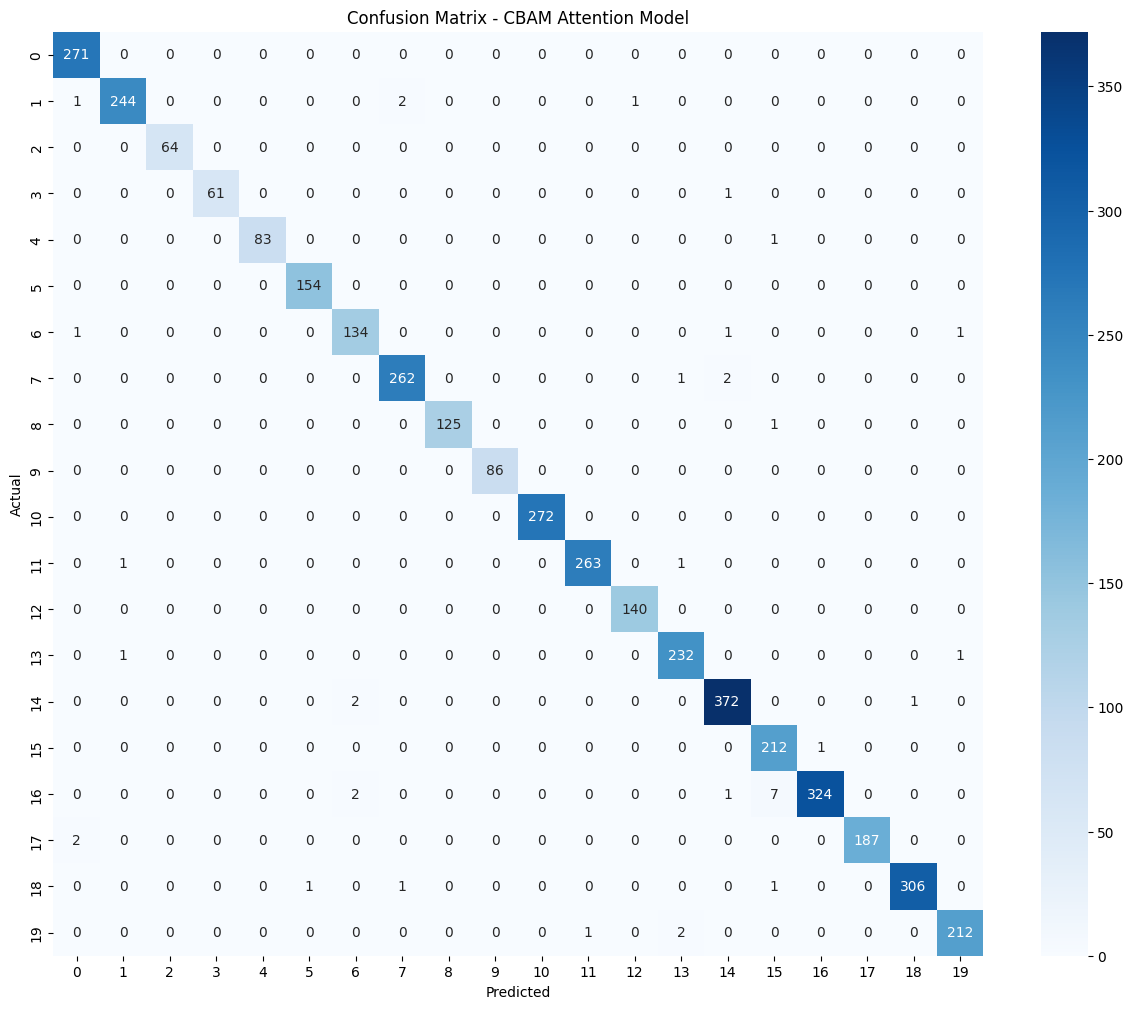


Classification Report for CBAM Attention Model:
              precision    recall  f1-score   support

     Class_0       0.99      1.00      0.99       271
     Class_1       0.99      0.98      0.99       248
     Class_2       1.00      1.00      1.00        64
     Class_3       1.00      0.98      0.99        62
     Class_4       1.00      0.99      0.99        84
     Class_5       0.99      1.00      1.00       154
     Class_6       0.97      0.98      0.97       137
     Class_7       0.99      0.99      0.99       265
     Class_8       1.00      0.99      1.00       126
     Class_9       1.00      1.00      1.00        86
    Class_10       1.00      1.00      1.00       272
    Class_11       1.00      0.99      0.99       265
    Class_12       0.99      1.00      1.00       140
    Class_13       0.98      0.99      0.99       234
    Class_14       0.99      0.99      0.99       375
    Class_15       0.95      1.00      0.97       213
    Class_16       1.00      0.9

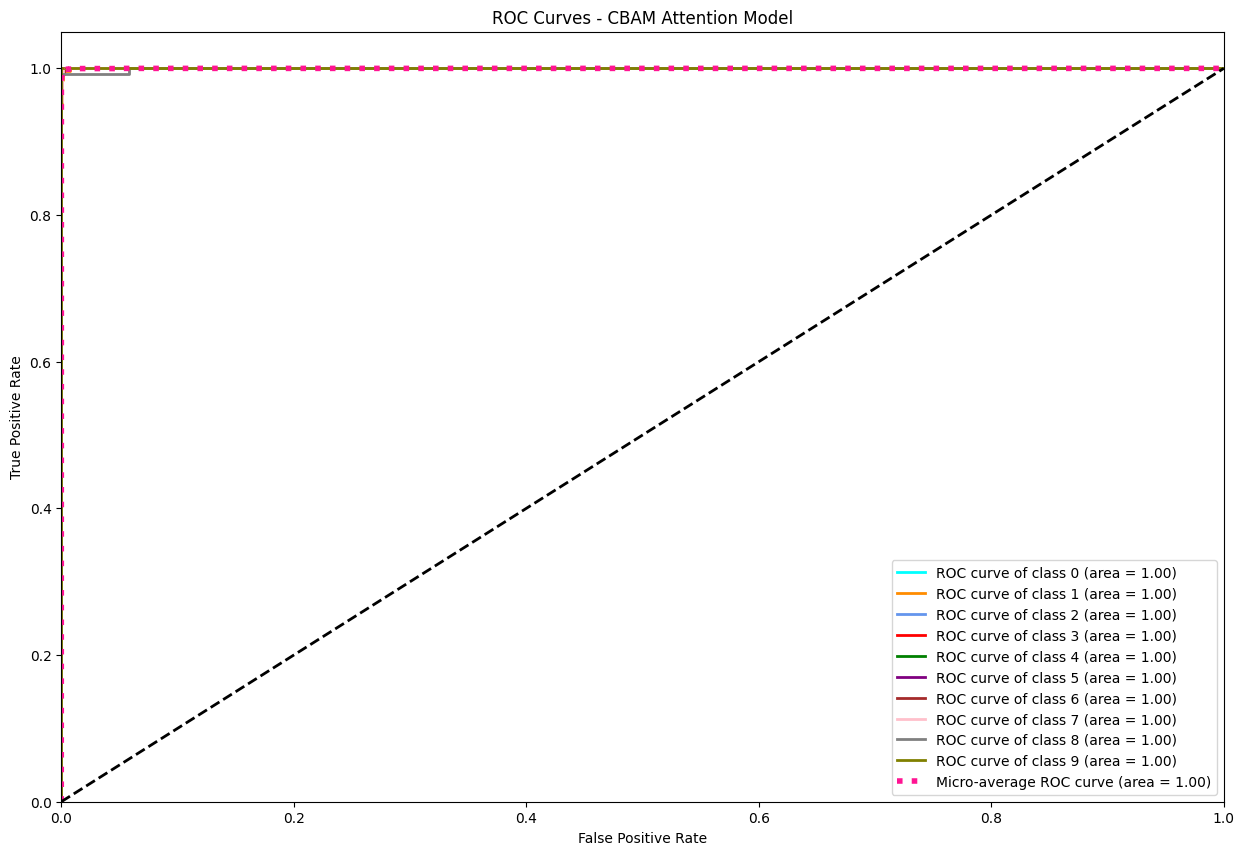


SUMMARY OF IMPROVEMENTS
Baseline CNN Accuracy: 0.9785
Best Attention (CBAM) CNN Accuracy: 0.9904
Improvement: 0.0119 (1.21%)

Performance Comparison of Attention Mechanisms:
  Attention Type  Test Accuracy  Training Time (min)  Test Time (sec)
0           CBAM         0.9904             307.8367          41.3346


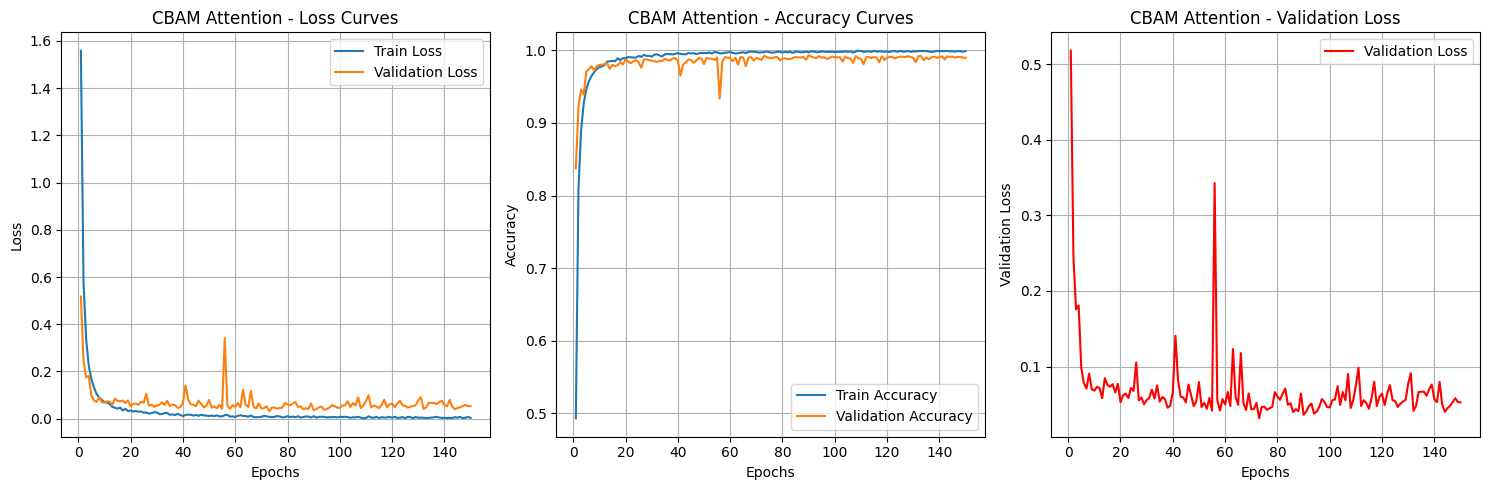


Generating Grad-CAM for CBAM Attention Model...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


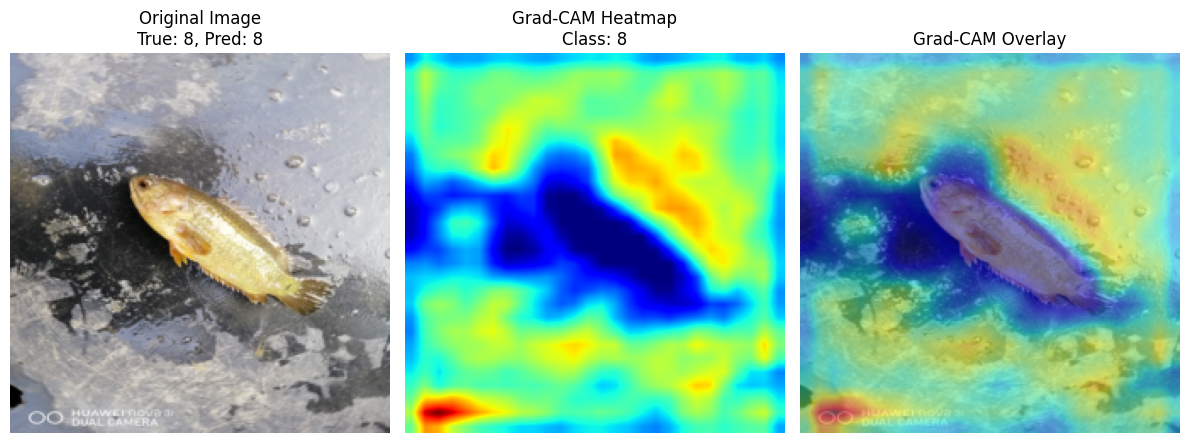

Grad-CAM successfully applied and saved.


In [20]:
# Now let's run the attention-based models
attention_types = ['cbam']
attention_results = {}
print("Starting Attention-Based Model Training...")

for attention_type in attention_types:
    print(f"\n{'='*50}")
    print(f"Training FishNet with {attention_type.upper()} Attention")
    print(f"{'='*50}")
    model_attn = create_attention_model(num_classes=20, attention_type=attention_type)
    criterion_attn = nn.CrossEntropyLoss()
    optimizer_attn = torch.optim.Adam(model_attn.parameters(), lr=0.0001)
    start_time = time.time()
    train_loss_history_attn, train_acc_history_attn, val_loss_history_attn, val_acc_history_attn = train_model(
        model_attn, criterion_attn, optimizer_attn,
        dataloader_train_dataset, dataloader_valid_dataset,
        num_epochs=150,
        save_path_checkpoints=f"checkpoints_{attention_type}"
    )
    training_time_attn = time.time() - start_time
    data_attn = {
        'Epoch': list(range(1, len(train_loss_history_attn) + 1)),
        'Train Loss': train_loss_history_attn,
        'Train Accuracy': train_acc_history_attn,
        'Validation Loss': val_loss_history_attn,
        'Validation Accuracy': val_acc_history_attn
    }
    history_attn = pd.DataFrame(data_attn)
    history_attn.to_excel(f'/kaggle/working/training_data_{attention_type}.xlsx', index=False)
    checkpoint_path_attn = f"checkpoints_{attention_type}/model.pt"
    checkpoint_attn = torch.load(checkpoint_path_attn, map_location=device)
    model_attn.load_state_dict(checkpoint_attn['model_weight'])
    model_attn.eval()
    start_time = time.time()
    test_loss_attn, test_accuracy_attn = evaluate_model(model_attn, criterion_attn, dataloader_test_dataset)
    test_time_attn = time.time() - start_time
    print(f"Test Accuracy for {attention_type.upper()}: {test_accuracy_attn:.4f}")
    print(f"Training Time: {training_time_attn/60:.2f} minutes")
    print(f"Test Time: {test_time_attn:.2f} seconds")
    attention_results[attention_type] = {
        'model': model_attn,
        'test_accuracy': test_accuracy_attn,
        'training_time': training_time_attn,
        'test_time': test_time_attn,
        'checkpoint_path': checkpoint_path_attn
    }

# Extract features and apply ML classifiers for each attention model
ml_results_attention = {}
for attention_type in attention_types:
    print(f"\nProcessing {attention_type.upper()} Attention Model for ML Classifiers...")
    model_attn = attention_results[attention_type]['model']
    feature_extractor_attn = create_feature_extractor_with_attention(model_attn)
    feature_extractor_attn.eval()
    X_train_feats_attn, y_train_attn = extract_features(feature_extractor_attn, dataloader_train_dataset, device)
    X_test_feats_attn, y_test_attn = extract_features(feature_extractor_attn, dataloader_test_dataset, device)
    scaler_attn = StandardScaler()
    X_train_scaled_attn = scaler_attn.fit_transform(X_train_feats_attn)
    X_test_scaled_attn = scaler_attn.transform(X_test_feats_attn)
    classifiers_attn = {
        "SVM": SVC(kernel='rbf', probability=True, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42, n_jobs=-1)
    }
    results_attn = []
    for name, clf in classifiers_attn.items():
        print(f"  Training {name}...")
        start = time.time()
        if name == "SVM":
            clf.fit(X_train_feats_attn, y_train_attn)
            train_time = time.time() - start
            pred_start = time.time()
            y_pred = clf.predict(X_test_feats_attn)
            y_proba = clf.predict_proba(X_test_feats_attn)
            test_time = time.time() - pred_start
        else:
            clf.fit(X_train_scaled_attn, y_train_attn)
            train_time = time.time() - start
            pred_start = time.time()
            y_pred = clf.predict(X_test_scaled_attn)
            y_proba = clf.predict_proba(X_test_scaled_attn)
            test_time = time.time() - pred_start
        acc = accuracy_score(y_test_attn, y_pred)
        prec = precision_score(y_test_attn, y_pred, average='weighted')
        rec = recall_score(y_test_attn, y_pred, average='weighted')
        f1 = f1_score(y_test_attn, y_pred, average='weighted')
        try:
            auc_score = roc_auc_score(y_test_attn, y_proba, average='weighted', multi_class='ovr') if y_proba.shape[1] > 2 else roc_auc_score(y_test_attn, y_proba[:, 1])
        except:
            auc_score = float('nan')
        results_attn.append({
            "Model": f"{attention_type.upper()}+{name}",
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC-AUC": auc_score,
            "Train Time (s)": train_time,
            "Test Time (s)": test_time
        })
    ml_results_attention[attention_type] = pd.DataFrame(results_attn)
print("Attention-based models training and evaluation completed!")

# Create comprehensive comparison results
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*80)
all_results = []
baseline_cnn_result = {
    "Model": "Baseline CNN",
    "Accuracy": 0.9785,
    "Precision": 0.9789,
    "Recall": 0.9785,
    "F1-Score": 0.9785,
    "ROC-AUC": 0.9996,
    "Train Time (s)": "N/A",
    "Test Time (s)": "N/A"
}
all_results.append(baseline_cnn_result)
for attention_type in attention_types:
    attn_cnn_result = {
        "Model": f"{attention_type.upper()} CNN",
        "Accuracy": attention_results[attention_type]['test_accuracy'],
        "Precision": "N/A",
        "Recall": "N/A",
        "F1-Score": "N/A",
        "ROC-AUC": "N/A",
        "Train Time (s)": attention_results[attention_type]['training_time'],
        "Test Time (s)": attention_results[attention_type]['test_time']
    }
    all_results.append(attn_cnn_result)
    for _, row in ml_results_attention[attention_type].iterrows():
        all_results.append(row.to_dict())

# Detailed evaluation for best attention model
best_attention_type = max(attention_results.keys(), key=lambda k: attention_results[k]['test_accuracy'])
print(f"\nDetailed Evaluation for Best Attention Model: {best_attention_type.upper()}")
best_model = attention_results[best_attention_type]['model']

# Class accuracy
class_acc_attn = class_accuracy(best_model, dataloader_test_dataset, 20)
print("\nClass-wise Accuracy for Best Attention Model:")
for i in range(20):
    print(f"Class {i} Accuracy: {class_acc_attn[i]:.4f}")

# Confusion Matrix
y_true_attn = []
y_pred_attn = []
best_model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_attn.extend(labels.cpu().numpy())
        y_pred_attn.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true_attn, y_pred_attn)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_attention_type.upper()} Attention Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'/kaggle/working/confusion_matrix_{best_attention_type}.png')
plt.show()

# Classification Report
class_names = [f"Class_{i}" for i in range(20)]
print(f"\nClassification Report for {best_attention_type.upper()} Attention Model:")
print(classification_report(y_true_attn, y_pred_attn, target_names=class_names))

# ROC Curve
y_test_binarized = label_binarize(y_true_attn, classes=range(20))
n_classes = y_test_binarized.shape[1]
y_proba_attn = []
best_model.eval()
with torch.no_grad():
    for inputs, _ in dataloader_test_dataset:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_proba_attn.extend(probs.cpu().numpy())
y_proba_attn = np.array(y_proba_attn)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_attn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba_attn.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
                'cyan', 'magenta', 'yellow', 'black', 'lime', 'teal', 'lavender', 'maroon', 'navy', 'gold'])
for i, color in zip(range(min(10, n_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_attention_type.upper()} Attention Model')
plt.legend(loc="lower right")
plt.savefig(f'/kaggle/working/roc_curves_{best_attention_type}.png')
plt.show()

# Summary of improvements
print("\n" + "="*80)
print("SUMMARY OF IMPROVEMENTS")
print("="*80)
baseline_acc = 0.9785
best_attention_acc = attention_results[best_attention_type]['test_accuracy']
print(f"Baseline CNN Accuracy: {baseline_acc:.4f}")
print(f"Best Attention ({best_attention_type.upper()}) CNN Accuracy: {best_attention_acc:.4f}")
print(f"Improvement: {best_attention_acc - baseline_acc:.4f} ({((best_attention_acc - baseline_acc)/baseline_acc)*100:.2f}%)")

# Performance comparison table
performance_comparison = []
for attn_type in attention_types:
    performance_comparison.append({
        'Attention Type': attn_type.upper(),
        'Test Accuracy': attention_results[attn_type]['test_accuracy'],
        'Training Time (min)': attention_results[attn_type]['training_time']/60,
        'Test Time (sec)': attention_results[attn_type]['test_time']
    })
perf_df = pd.DataFrame(performance_comparison)
print("\nPerformance Comparison of Attention Mechanisms:")
print(perf_df.round(4))
perf_df.to_excel('/kaggle/working/attention_performance_comparison.xlsx', index=False)

# Training curves
for attention_type in attention_types:
    try:
        history_attn = pd.read_excel(f'/kaggle/working/training_data_{attention_type}.xlsx')
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(history_attn['Epoch'], history_attn['Train Loss'], label='Train Loss')
        plt.plot(history_attn['Epoch'], history_attn['Validation Loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{attention_type.upper()} Attention - Loss Curves')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 3, 2)
        plt.plot(history_attn['Epoch'], history_attn['Train Accuracy'], label='Train Accuracy')
        plt.plot(history_attn['Epoch'], history_attn['Validation Accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'{attention_type.upper()} Attention - Accuracy Curves')
        plt.legend()
        plt.grid(True)
        plt.subplot(1, 3, 3)
        plt.plot(history_attn['Epoch'], history_attn['Validation Loss'], 'r-', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Loss')
        plt.title(f'{attention_type.upper()} Attention - Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'/kaggle/working/training_curves_{attention_type}.png')
        plt.show()
    except Exception as e:
        print(f"Could not plot training curves for {attention_type}: {e}")

# ==================== GRAD-CAM SECTION ADDED HERE ====================
# Define GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        target = output[:, class_idx]
        target.backward()
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224,224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Apply Grad-CAM to the best attention model
print(f"\nGenerating Grad-CAM for {best_attention_type.upper()} Attention Model...")

# Select the last conv layer
target_layer = best_model.features.conv4
gradcam = GradCAM(model=best_model, target_layer=target_layer)

# Pick a test image
img_tensor, true_label = test_dataset[0]
img_tensor_with_batch = img_tensor.unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = best_model(img_tensor_with_batch)
    pred_label = output.argmax(dim=1).item()

# Generate CAM
cam = gradcam.generate_cam(img_tensor_with_batch, class_idx=pred_label)

# Denormalize image
img = img_tensor.permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f"Original Image\nTrue: {true_label}, Pred: {pred_label}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title(f"Grad-CAM Heatmap\nClass: {pred_label}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.tight_layout()
plt.savefig(f"/kaggle/working/gradcam_{best_attention_type}_overlay.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Grad-CAM successfully applied and saved.")


Measuring inference time per class for CBAM Attention Model...


Timing Inference:   0%|          | 0/4043 [00:00<?, ?it/s]


Inference Time per Class (sorted by speed):
+----+-----------+-------------------------+---------------------+--------------+
|    |   Class   | Avg Inference Time (ms) |      Std (ms)       | Sample Count |
+----+-----------+-------------------------+---------------------+--------------+
| 0  |  Chapila  |   3.5080499947071075    | 0.2259803324128095  |      64      |
| 1  |  Mrigel   |   3.5308248856488396    | 0.21085474913590557 |     272      |
| 2  |  Tengra   |   3.5318452258442723    | 0.1674819799902749  |     215      |
| 3  | KalBaush  |    3.534017688166486    | 0.17027495915973895 |     137      |
| 4  |   Puti    |   3.5375163086459165    | 0.19044808623500342 |     234      |
| 5  |  Pangas   |   3.5388912473406107    | 0.1675987613673078  |     140      |
| 6  |   Pabda   |   3.5426211806963073    |  0.266116182961943  |     265      |
| 7  |   Taki    |   3.5462979071154566    | 0.28014897254474413 |     334      |
| 8  |   Foli    |    3.547220003037226    | 0.217529

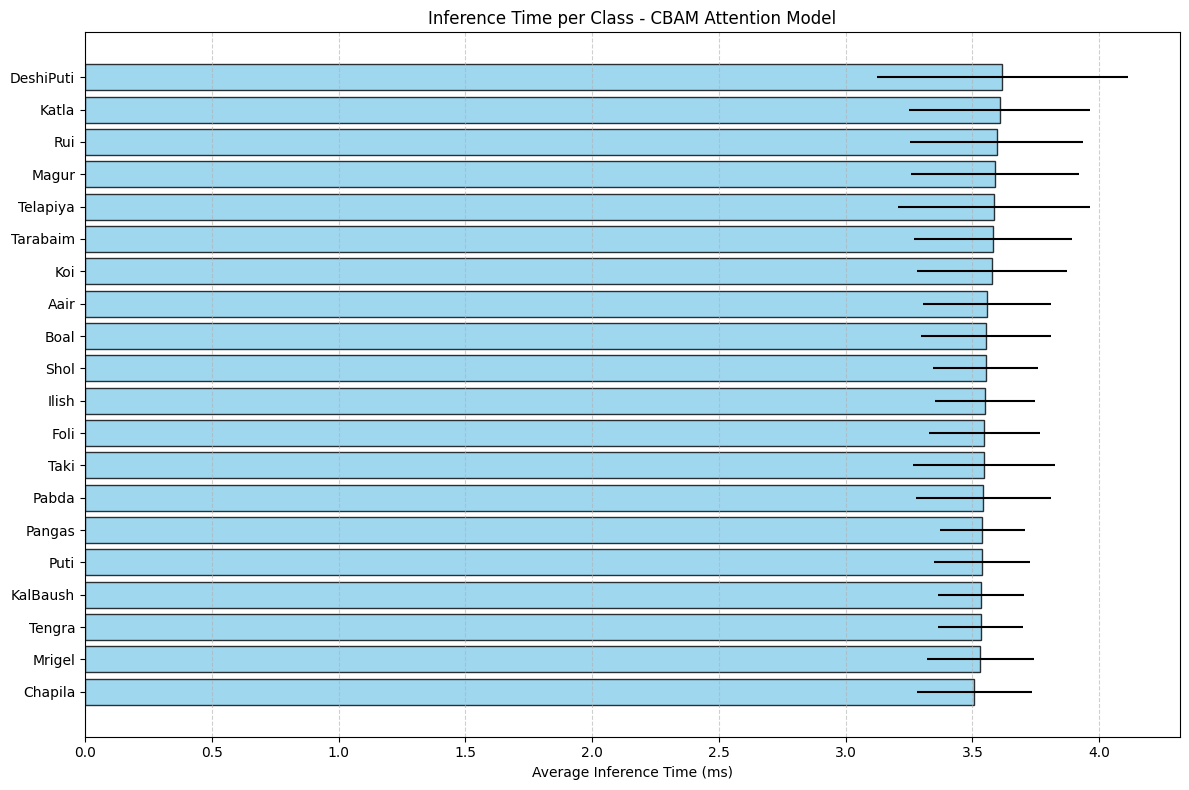

In [21]:
# ==================== INFERENCE TIME PER CLASS ====================

print(f"\nMeasuring inference time per class for {best_attention_type.upper()} Attention Model...")

# Set model to evaluation mode
best_model.eval()

# Lists to store results
class_names_list = list(train_dataset.label_map.keys())  # ['Class_0', ..., 'Class_19'] or actual species names
class_times = {cls: [] for cls in class_names_list}  # Accumulate times per class
label_to_name = {idx: name for name, idx in train_dataset.label_map.items()}

# Warm-up (important for accurate timing on GPU)
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    for _ in range(5):
        _ = best_model(dummy_input)

# Inference with timing
with torch.no_grad():
    for img_tensor, label in tqdm(test_dataset, desc="Timing Inference"):
        img_tensor_with_batch = img_tensor.unsqueeze(0).to(device)
        
        # Synchronize before timing (for accurate GPU timing)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        start_time = time.time()
        
        # Forward pass
        output = best_model(img_tensor_with_batch)
        
        # Synchronize after (for accurate GPU timing)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        end_time = time.time()
        
        inference_time = end_time - start_time
        class_name = label_to_name[label]
        class_times[class_name].append(inference_time)

# Compute average time per class
avg_time_per_class = {cls: np.mean(times) * 1000 for cls, times in class_times.items()}  # in milliseconds
std_time_per_class = {cls: np.std(times) * 1000 for cls, times in class_times.items()}  # std in ms

# Convert to DataFrame
time_df = pd.DataFrame({
    'Class': list(avg_time_per_class.keys()),
    'Avg Inference Time (ms)': list(avg_time_per_class.values()),
    'Std (ms)': list(std_time_per_class.values()),
    'Sample Count': [len(class_times[cls]) for cls in avg_time_per_class.keys()]
})

# Sort by time
time_df = time_df.sort_values('Avg Inference Time (ms)', ascending=True).reset_index(drop=True)

# Print table
print("\nInference Time per Class (sorted by speed):")
print(tabulate(time_df, headers="keys", tablefmt="pretty", floatfmt=(".1f", ".3f", ".3f", ".0f")))

# Save to CSV
time_df.to_csv("/kaggle/working/inference_time_per_class.csv", index=False)
print(f"\n✅ Inference time results saved to '/kaggle/working/inference_time_per_class.csv'")

# Plot
plt.figure(figsize=(12, 8))
plt.barh(time_df['Class'], time_df['Avg Inference Time (ms)'], xerr=time_df['Std (ms)'], color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Average Inference Time (ms)')
plt.title(f'Inference Time per Class - {best_attention_type.upper()} Attention Model')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("/kaggle/working/inference_time_per_class.png", dpi=150, bbox_inches='tight')
plt.show()